In [1]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, get_data, get_vars, get_constit_vars
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_auc_score, roc_curve
import os
import glob
from tqdm.notebook import tqdm

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

2023-09-22 14:52:46.183743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Quark jets, R = 0.8

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

vars = ['z','eta','phi']
hdata = get_constit_vars('q',vars,hlevel=True,efrac=False,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_constit_vars('q',vars,hlevel=False,efrac=False,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

del hdata, pdata, htrain, hval, ptrain, pval

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

del perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [3]:
import vector

hmult = np.count_nonzero(htest[:,:,0],axis=1)
pmult = np.count_nonzero(ptest[:,:,0],axis=1)

vars = ['pt','eta','phi','e']
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000
hdata = get_vars('q',vars,hlevel=True,efrac=False,base=base,nmax=nmax,wta=True,sumVars=True)
h1, h2 = train_test_split(hdata,train_size=0.5,random_state=rng1)
h2, h3 = train_test_split(h2,train_size=0.5,random_state=rng2)

pdata = get_vars('q',vars,hlevel=False,efrac=False,base=base,nmax=nmax,wta=True,sumVars=True)
p1, p2 = train_test_split(pdata,train_size=0.5,random_state=rng1)
p2, p3 = train_test_split(p2,train_size=0.5,random_state=rng2)

del hdata, pdata, h1, h3, p1, p3

hvec = vector.array({"pt":h2[:,0],"eta":h2[:,1],"phi":h2[:,2],"E":h2[:,3]})
pvec = vector.array({"pt":p2[:,0],"eta":p2[:,1],"phi":p2[:,2],"E":p2[:,3]})

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [4]:
# Evaluate mean/std of AUCs for spectral and non-spectral EFNs
efns = glob.glob("keras_models_wta/qjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_wta/qjet_spectralEFN_zpT_iter*.keras")

efn_aucs = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000)
    auc = roc_auc_score(test_labels, preds)
    efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000)
    auc = roc_auc_score(test_labels, preds)
    spectral_efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = [a if a>=0.5 else 1-a for a in spectral_efn_aucs]

2023-09-22 14:45:24.725441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:45:25.788214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:45:25.788615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:45:25.789774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

 4/10 [===========>..................] - ETA: 0s 

2023-09-22 14:45:29.872437: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 0s 41ms/step


In [5]:
print(f"EFN : AUC = {np.mean(efn_aucs):.4f} +/- {np.std(efn_aucs):.4f}")
print(f"Spectral EFN : AUC = {np.mean(spectral_efn_aucs):.4f} +/- {np.std(spectral_efn_aucs):.4f}")

EFN : AUC = 0.9571 +/- 0.0046
Spectral EFN : AUC = 0.5531 +/- 0.0014


In [6]:
# Computing EFN scores for comparison with EMD
efns = glob.glob("keras_models_wta/qjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_wta/qjet_spectralEFN_zpT_iter*.keras")

hlevel_efn_scores = []
plevel_efn_scores = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000)
    hlevel_efn_scores.append(preds_hlevel)
    plevel_efn_scores.append(preds_plevel)
    del efn
    gc.collect()

hlevel_spectral_efn_scores = []
plevel_spectral_efn_scores = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000)
    hlevel_spectral_efn_scores.append(preds_hlevel)
    plevel_spectral_efn_scores.append(preds_plevel)
    del efn
    gc.collect()
    
hlevel_efn_scores = np.concatenate(hlevel_efn_scores,axis=1)
plevel_efn_scores = np.concatenate(plevel_efn_scores,axis=1)
hlevel_spectral_efn_scores = np.concatenate(hlevel_spectral_efn_scores,axis=1)
plevel_spectral_efn_scores = np.concatenate(plevel_spectral_efn_scores,axis=1)

5/5 [==============================] - 0s 44ms/step


In [7]:
from scipy.special import logit, expit
hlevel_efn_scores_logit = logit(hlevel_efn_scores)
plevel_efn_scores_logit = logit(plevel_efn_scores)
hlevel_spectral_efn_scores_logit = logit(hlevel_spectral_efn_scores)
plevel_spectral_efn_scores_logit = logit(plevel_spectral_efn_scores)

In [8]:
# computing emds
from energyflow.emd import emd_wasserstein, emds_wasserstein
htest_trim = [h[h[:,0]>0] for h in htest]
ptest_trim = [p[p[:,0]>0] for p in ptest]

emds = []
for h,p in tqdm(zip(htest_trim,ptest_trim)):
    emds.append(emd_wasserstein(h,p,R=0.8,norm=False))
    
# computing difference in efn scores
delta_efn = np.abs(hlevel_efn_scores-plevel_efn_scores)
delta_efn_logits = np.abs(hlevel_efn_scores_logit-plevel_efn_scores_logit)
delta_spectral_efn = np.abs(hlevel_spectral_efn_scores-plevel_spectral_efn_scores)
delta_spectral_efn_logits = np.abs(hlevel_spectral_efn_scores_logit-plevel_spectral_efn_scores_logit)

# computing angularity lambda^1 (1-Lipschitz)
z_h = htest[:,:,0]
theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
angularity_h = np.sum(theta_h*z_h,axis=1)

z_p = ptest[:,:,0]
theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
angularity_p = np.sum(theta_p*z_p,axis=1)

delta_lambda1 = np.abs(angularity_p-angularity_h)

kap = 2
bet = 0
ptD_p = np.sum((theta_p**bet)*(z_p**kap),axis=1)
ptD_h = np.sum((theta_h**bet)*(z_h**kap),axis=1)

0it [00:00, ?it/s]

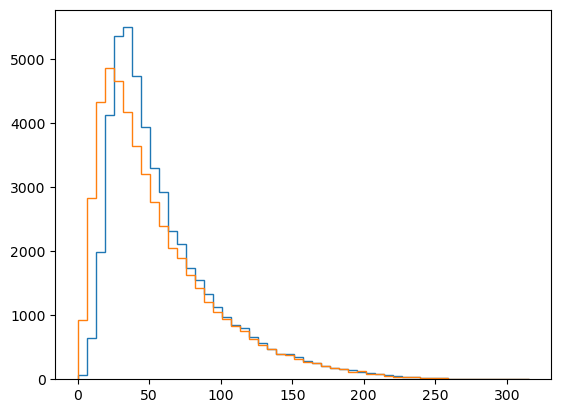

In [9]:
plt.figure()
h1,bins,_ = plt.hist(hvec.mass,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.mass,bins=bins,histtype='step')

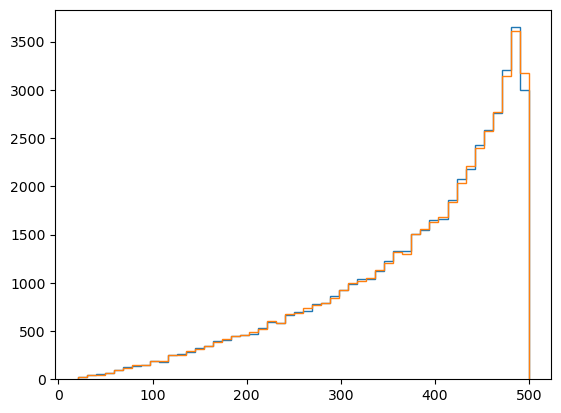

In [10]:
plt.figure()
h1,bins,_ = plt.hist(hvec.pt,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.pt,bins=bins,histtype='step')

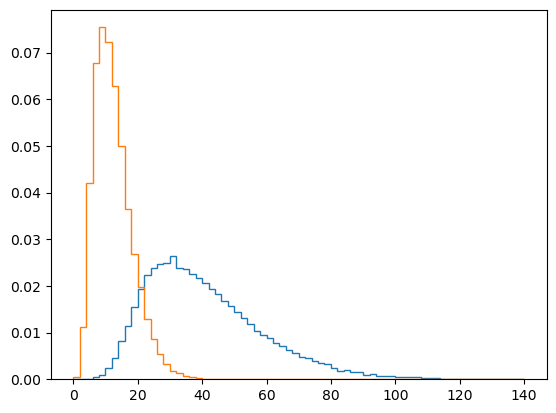

In [11]:
plt.figure()
bins = np.arange(0,142,2)
h1,bins,_ = plt.hist(hmult,bins=bins,histtype='step',density=True)
h1,bins,_ = plt.hist(pmult,bins=bins,histtype='step',density=True)

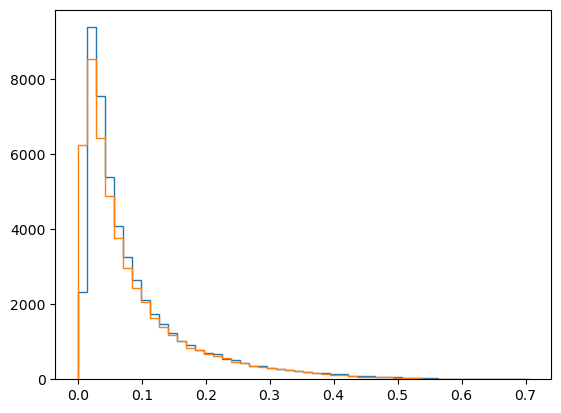

In [12]:
plt.figure()
h1,bins,_ = plt.hist(angularity_h,bins=50,histtype='step')
h1,bins,_ = plt.hist(angularity_p,bins=bins,histtype='step')

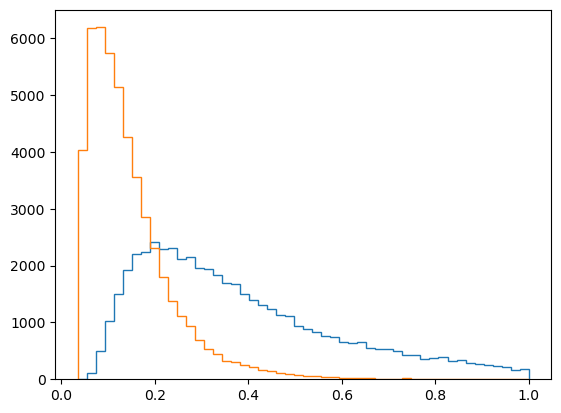

In [13]:
plt.figure()
h1,bins,_ = plt.hist(ptD_p,bins=50,histtype='step')
h1,bins,_ = plt.hist(ptD_h,bins=bins,histtype='step')

In [14]:
# Write output file
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2qq_WTA_testSet_outputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("jet1_pt_parton",data=pvec.pt)
    f.create_dataset("jet1_eta_parton",data=pvec.eta)
    f.create_dataset("jet1_phi_parton",data=pvec.phi)
    f.create_dataset("jet1_mass_parton",data=pvec.mass)
    f.create_dataset("jet1_EFN_scores_parton",data=plevel_efn_scores)
    f.create_dataset("jet1_EFN_logits_parton",data=plevel_efn_scores_logit)
    f.create_dataset("jet1_spectralEFN_scores_parton",data=plevel_spectral_efn_scores)
    f.create_dataset("jet1_spectralEFN_logits_parton",data=plevel_spectral_efn_scores_logit)
    f.create_dataset("jet1_multiplicity_parton",data=pmult)
    f.create_dataset("jet1_ptD_parton",data=ptD_p)
    f.create_dataset("jet1_lambda1_parton",data=angularity_p)
    
    f.create_dataset("jet1_pt_hadron",data=hvec.pt)
    f.create_dataset("jet1_eta_hadron",data=hvec.eta)
    f.create_dataset("jet1_phi_hadron",data=hvec.phi)
    f.create_dataset("jet1_mass_hadron",data=hvec.mass)
    f.create_dataset("jet1_EFN_scores_hadron",data=hlevel_efn_scores)
    f.create_dataset("jet1_EFN_logits_hadron",data=hlevel_efn_scores_logit)
    f.create_dataset("jet1_spectralEFN_scores_hadron",data=hlevel_spectral_efn_scores)
    f.create_dataset("jet1_spectralEFN_logits_hadron",data=hlevel_spectral_efn_scores_logit)
    f.create_dataset("jet1_multiplicity_hadron",data=hmult)
    f.create_dataset("jet1_ptD_hadron",data=ptD_h)
    f.create_dataset("jet1_lambda1_hadron",data=angularity_h)
    
    f.create_dataset("parton_hadron_emd",data=np.array(emds))

In [15]:
# computing PFN scores
pfns = glob.glob("keras_models_PFN_wta/qjet_PFN_zpT_iter*.keras")
spectral_pfns = glob.glob("keras_models_PFN_wta/qjet_spectralPFN_zpT_iter*.keras")

hlevel_pfn_scores = []
plevel_pfn_scores = []
for pfname in pfns:
    pfn = keras.models.load_model(pfname)
    preds_hlevel = pfn.predict(htest,batch_size=10000)
    preds_plevel = pfn.predict(ptest,batch_size=10000)
    hlevel_pfn_scores.append(preds_hlevel)
    plevel_pfn_scores.append(preds_plevel)
    del pfn
    gc.collect()

hlevel_spectral_pfn_scores = []
plevel_spectral_pfn_scores = []
for pfname in spectral_pfns:
    pfn = keras.models.load_model(pfname)
    preds_hlevel = pfn.predict(htest,batch_size=10000)
    preds_plevel = pfn.predict(ptest,batch_size=10000)
    hlevel_spectral_pfn_scores.append(preds_hlevel)
    plevel_spectral_pfn_scores.append(preds_plevel)
    del pfn
    gc.collect()
    
hlevel_pfn_scores = np.concatenate(hlevel_pfn_scores,axis=1)
plevel_pfn_scores = np.concatenate(plevel_pfn_scores,axis=1)
hlevel_spectral_pfn_scores = np.concatenate(hlevel_spectral_pfn_scores,axis=1)
plevel_spectral_pfn_scores = np.concatenate(plevel_spectral_pfn_scores,axis=1)

from scipy.special import logit, expit
hlevel_pfn_scores_logit = logit(hlevel_pfn_scores)
plevel_pfn_scores_logit = logit(plevel_pfn_scores)
hlevel_spectral_pfn_scores_logit = logit(hlevel_spectral_pfn_scores)
plevel_spectral_pfn_scores_logit = logit(plevel_spectral_pfn_scores)

5/5 [==============================] - 0s 45ms/step


In [16]:
# adding PFN scores to output file
# Write output file
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2qq_WTA_testSet_outputs_v2_pTinclusive_R1.0.h5","r+") as f:
    f.create_dataset("jet1_PFN_scores_parton",data=plevel_pfn_scores)
    f.create_dataset("jet1_PFN_logits_parton",data=plevel_pfn_scores_logit)
    f.create_dataset("jet1_spectralPFN_scores_parton",data=plevel_spectral_pfn_scores)
    f.create_dataset("jet1_spectralPFN_logits_parton",data=plevel_spectral_pfn_scores_logit)
    
    f.create_dataset("jet1_PFN_scores_hadron",data=hlevel_pfn_scores)
    f.create_dataset("jet1_PFN_logits_hadron",data=hlevel_pfn_scores_logit)
    f.create_dataset("jet1_spectralPFN_scores_hadron",data=hlevel_spectral_pfn_scores)
    f.create_dataset("jet1_spectralPFN_logits_hadron",data=hlevel_spectral_pfn_scores_logit)
    
    # write constituent (z,theta) for computing angularities
    z_h = htest[:,:,0]
    theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
    z_p = ptest[:,:,0]
    theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
    f.create_dataset("jet1_z_hadron",data=z_h)
    f.create_dataset("jet1_theta_hadron",data=theta_h)
    f.create_dataset("jet1_z_parton",data=z_p)
    f.create_dataset("jet1_theta_parton",data=theta_p)

## Plots

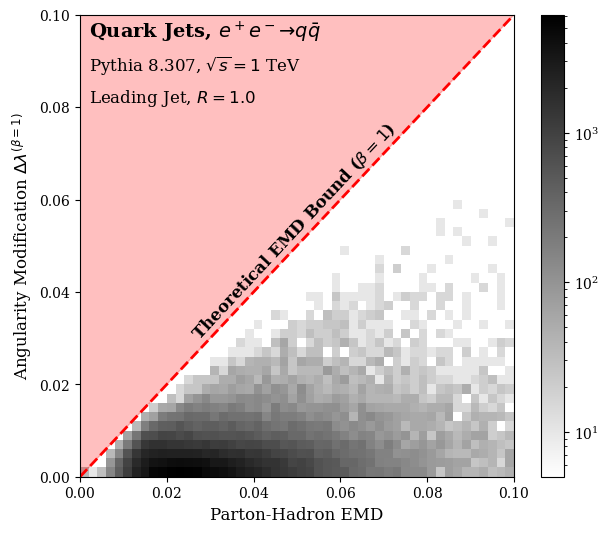

In [15]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,delta_lambda1,bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"Angularity Modification $\Delta\lambda^{(\beta=1)}$",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/qjet_EMD_vs_lambda1_R1.0_pTinclusive.pdf")

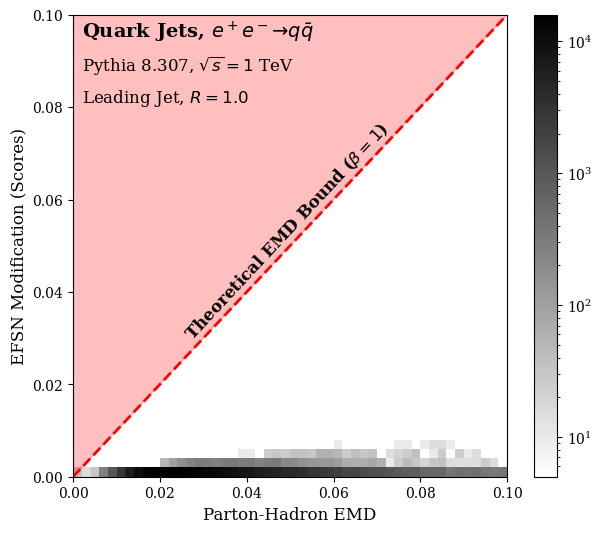

In [17]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_spectral_efn,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFSN Modification (Scores)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/qjet_EMD_vs_spectralEFNscores_R1.0_pTinclusive.pdf")

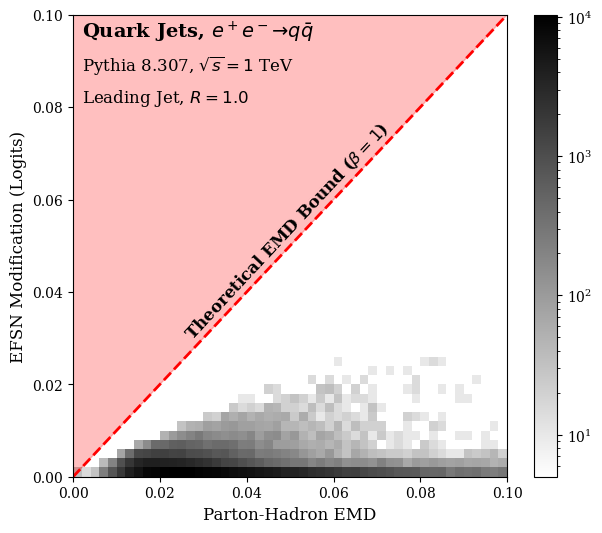

In [28]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_spectral_efn_logits,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFSN Modification (Logits)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
xtext = 0.002
ytext = 0.095
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(xtext,ytext,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(xtext,ytext-0.007,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(xtext,ytext-0.014,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/qjet_EMD_vs_spectralEFNlogits_R1.0_pTinclusive.pdf")

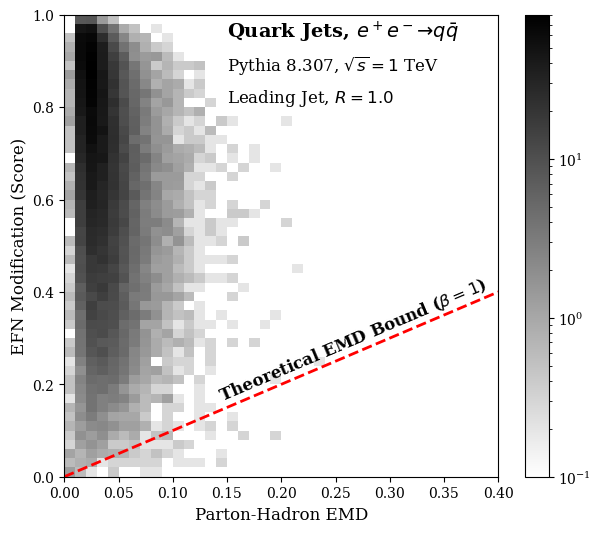

In [56]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.4
binstep = 0.01
binsx = np.arange(xmin,xmax+binstep,binstep)

ymin,ymax = 0,1
binstep = 0.02
binsy = np.arange(ymin,ymax+binstep,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_efn,axis=1),bins=(binsx,binsy),
                        norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFN Modification (Score)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = ymax*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
#plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.15,0.95,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.15,0.88,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.15,0.81,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.14,0.165,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=23)
plt.savefig("plots/qjet_EMD_vs_EFNscores_R1.0_pTinclusive.pdf")

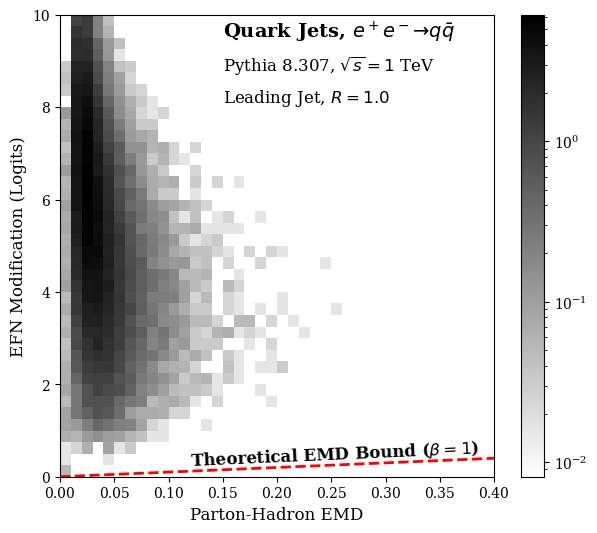

In [66]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.4
binstep = 0.01
binsx = np.arange(xmin,xmax+binstep,binstep)

ymin,ymax = 0,10
binstep = 0.25
binsy = np.arange(ymin,ymax+binstep,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_efn_logits,axis=1),bins=(binsx,binsy),
                        norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFN Modification (Logits)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = ymax*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
#plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.15,9.5,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.15,8.8,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.15,8.1,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.12,0.25,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=2.5)
plt.savefig("plots/qjet_EMD_vs_EFNlogits_R1.0_pTinclusive.pdf")

# Gluon jets, R = 0.8

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

vars = ['z','eta','phi']
hdata = get_constit_vars('g',vars,hlevel=True,efrac=False,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_constit_vars('g',vars,hlevel=False,efrac=False,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

del hdata, pdata, htrain, hval, ptrain, pval

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

del perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [3]:
import vector

hmult = np.count_nonzero(htest[:,:,0],axis=1)
pmult = np.count_nonzero(ptest[:,:,0],axis=1)

vars = ['pt','eta','phi','e']
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000
hdata = get_vars('g',vars,hlevel=True,efrac=False,base=base,nmax=nmax,wta=True,sumVars=True)
h1, h2 = train_test_split(hdata,train_size=0.5,random_state=rng1)
h2, h3 = train_test_split(h2,train_size=0.5,random_state=rng2)

pdata = get_vars('g',vars,hlevel=False,efrac=False,base=base,nmax=nmax,wta=True,sumVars=True)
p1, p2 = train_test_split(pdata,train_size=0.5,random_state=rng1)
p2, p3 = train_test_split(p2,train_size=0.5,random_state=rng2)

del hdata, pdata, h1, h3, p1, p3

hvec = vector.array({"pt":h2[:,0],"eta":h2[:,1],"phi":h2[:,2],"E":h2[:,3]})
pvec = vector.array({"pt":p2[:,0],"eta":p2[:,1],"phi":p2[:,2],"E":p2[:,3]})

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [4]:
# Evaluate mean/std of AUCs for spectral and non-spectral EFNs
efns = glob.glob("keras_models_wta/gjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_wta/gjet_spectralEFN_zpT_iter*.keras")

efn_aucs = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000)
    auc = roc_auc_score(test_labels, preds)
    efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000)
    auc = roc_auc_score(test_labels, preds)
    spectral_efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = [a if a>=0.5 else 1-a for a in spectral_efn_aucs]

2023-09-22 14:53:51.793914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:53:52.327484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:53:52.327831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 14:53:52.328566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

 3/10 [========>.....................] - ETA: 0s 

2023-09-22 14:53:55.654685: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 0s 41ms/step


In [5]:
print(f"EFN : AUC = {np.mean(efn_aucs):.4f} +/- {np.std(efn_aucs):.4f}")
print(f"Spectral EFN : AUC = {np.mean(spectral_efn_aucs):.4f} +/- {np.std(spectral_efn_aucs):.4f}")

EFN : AUC = 0.9604 +/- 0.0068
Spectral EFN : AUC = 0.5440 +/- 0.0009


In [ ]:
# Computing EFN scores for comparison with EMD
efns = glob.glob("keras_models_wta/gjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_wta/gjet_spectralEFN_zpT_iter*.keras")

hlevel_efn_scores = []
plevel_efn_scores = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000)
    hlevel_efn_scores.append(preds_hlevel)
    plevel_efn_scores.append(preds_plevel)
    del efn
    gc.collect()

hlevel_spectral_efn_scores = []
plevel_spectral_efn_scores = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000)
    hlevel_spectral_efn_scores.append(preds_hlevel)
    plevel_spectral_efn_scores.append(preds_plevel)
    del efn
    gc.collect()
    
hlevel_efn_scores = np.concatenate(hlevel_efn_scores,axis=1)
plevel_efn_scores = np.concatenate(plevel_efn_scores,axis=1)
hlevel_spectral_efn_scores = np.concatenate(hlevel_spectral_efn_scores,axis=1)
plevel_spectral_efn_scores = np.concatenate(plevel_spectral_efn_scores,axis=1)

3/5 [=================>............] - ETA: 0s

In [7]:
from scipy.special import logit, expit
hlevel_efn_scores_logit = logit(hlevel_efn_scores)
plevel_efn_scores_logit = logit(plevel_efn_scores)
hlevel_spectral_efn_scores_logit = logit(hlevel_spectral_efn_scores)
plevel_spectral_efn_scores_logit = logit(plevel_spectral_efn_scores)

In [8]:
# computing emds
from energyflow.emd import emd_wasserstein, emds_wasserstein
htest_trim = [h[h[:,0]>0] for h in htest]
ptest_trim = [p[p[:,0]>0] for p in ptest]

emds = []
for h,p in tqdm(zip(htest_trim,ptest_trim)):
    emds.append(emd_wasserstein(h,p,R=0.8,norm=False))
    
# computing difference in efn scores
delta_efn = np.abs(hlevel_efn_scores-plevel_efn_scores)
delta_efn_logits = np.abs(hlevel_efn_scores_logit-plevel_efn_scores_logit)
delta_spectral_efn = np.abs(hlevel_spectral_efn_scores-plevel_spectral_efn_scores)
delta_spectral_efn_logits = np.abs(hlevel_spectral_efn_scores_logit-plevel_spectral_efn_scores_logit)

# computing angularity lambda^1 (1-Lipschitz)
z_h = htest[:,:,0]
theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
angularity_h = np.sum(theta_h*z_h,axis=1)

z_p = ptest[:,:,0]
theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
angularity_p = np.sum(theta_p*z_p,axis=1)

delta_lambda1 = np.abs(angularity_p-angularity_h)

kap = 2
bet = 0
ptD_p = np.sum((theta_p**bet)*(z_p**kap),axis=1)
ptD_h = np.sum((theta_h**bet)*(z_h**kap),axis=1)

0it [00:00, ?it/s]

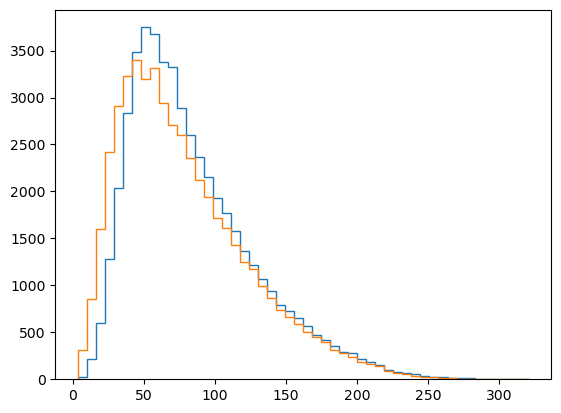

In [9]:
plt.figure()
h1,bins,_ = plt.hist(hvec.mass,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.mass,bins=bins,histtype='step')

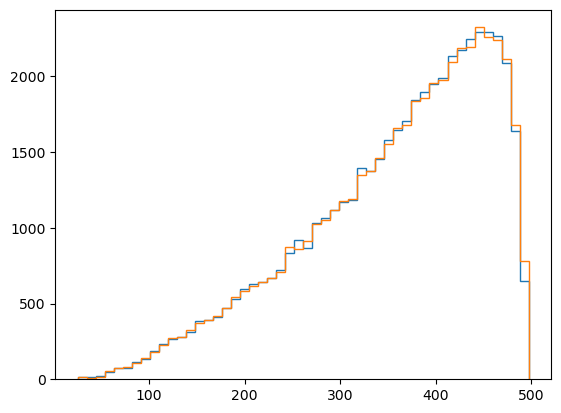

In [10]:
plt.figure()
h1,bins,_ = plt.hist(hvec.pt,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.pt,bins=bins,histtype='step')

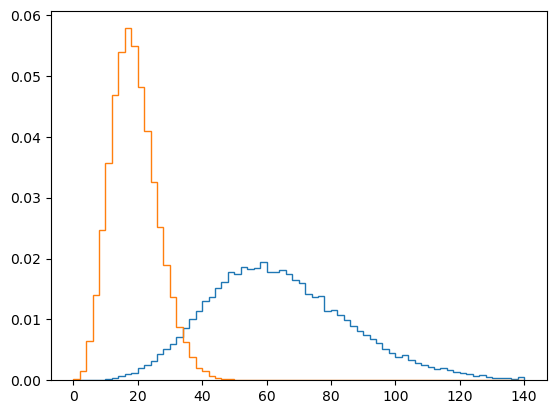

In [11]:
plt.figure()
bins = np.arange(0,142,2)
h1,bins,_ = plt.hist(hmult,bins=bins,histtype='step',density=True)
h1,bins,_ = plt.hist(pmult,bins=bins,histtype='step',density=True)

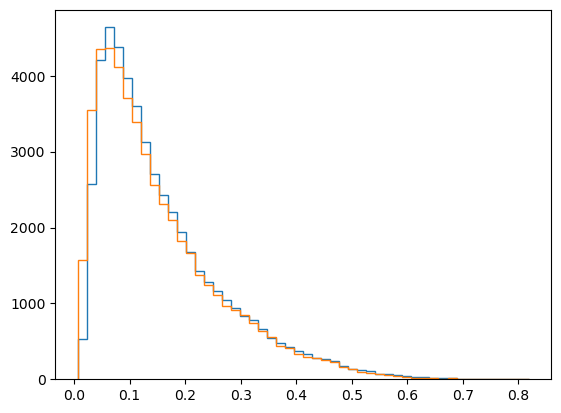

In [12]:
plt.figure()
h1,bins,_ = plt.hist(angularity_h,bins=50,histtype='step')
h1,bins,_ = plt.hist(angularity_p,bins=bins,histtype='step')

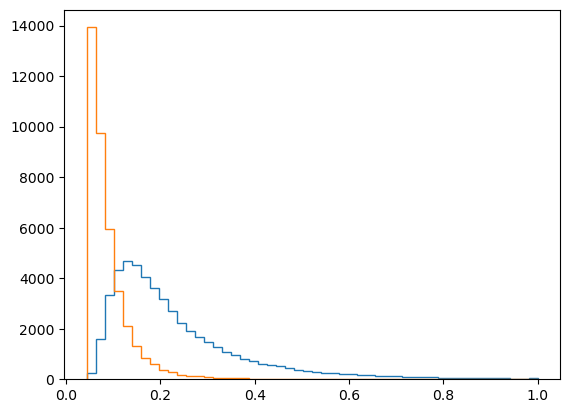

In [13]:
plt.figure()
h1,bins,_ = plt.hist(ptD_p,bins=50,histtype='step')
h1,bins,_ = plt.hist(ptD_h,bins=bins,histtype='step')

In [14]:
# Write output file
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2gg_WTA_testSet_outputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("jet1_pt_parton",data=pvec.pt)
    f.create_dataset("jet1_eta_parton",data=pvec.eta)
    f.create_dataset("jet1_phi_parton",data=pvec.phi)
    f.create_dataset("jet1_mass_parton",data=pvec.mass)
    f.create_dataset("jet1_EFN_scores_parton",data=plevel_efn_scores)
    f.create_dataset("jet1_EFN_logits_parton",data=plevel_efn_scores_logit)
    f.create_dataset("jet1_spectralEFN_scores_parton",data=plevel_spectral_efn_scores)
    f.create_dataset("jet1_spectralEFN_logits_parton",data=plevel_spectral_efn_scores_logit)
    f.create_dataset("jet1_multiplicity_parton",data=pmult)
    f.create_dataset("jet1_ptD_parton",data=ptD_p)
    f.create_dataset("jet1_lambda1_parton",data=angularity_p)
    
    f.create_dataset("jet1_pt_hadron",data=hvec.pt)
    f.create_dataset("jet1_eta_hadron",data=hvec.eta)
    f.create_dataset("jet1_phi_hadron",data=hvec.phi)
    f.create_dataset("jet1_mass_hadron",data=hvec.mass)
    f.create_dataset("jet1_EFN_scores_hadron",data=hlevel_efn_scores)
    f.create_dataset("jet1_EFN_logits_hadron",data=hlevel_efn_scores_logit)
    f.create_dataset("jet1_spectralEFN_scores_hadron",data=hlevel_spectral_efn_scores)
    f.create_dataset("jet1_spectralEFN_logits_hadron",data=hlevel_spectral_efn_scores_logit)
    f.create_dataset("jet1_multiplicity_hadron",data=hmult)
    f.create_dataset("jet1_ptD_hadron",data=ptD_h)
    f.create_dataset("jet1_lambda1_hadron",data=angularity_h)
    
    f.create_dataset("parton_hadron_emd",data=np.array(emds))

In [15]:
# computing PFN scores
pfns = glob.glob("keras_models_PFN_wta/gjet_PFN_zpT_iter*.keras")
spectral_pfns = glob.glob("keras_models_PFN_wta/gjet_spectralPFN_zpT_iter*.keras")

hlevel_pfn_scores = []
plevel_pfn_scores = []
for pfname in pfns:
    pfn = keras.models.load_model(pfname)
    preds_hlevel = pfn.predict(htest,batch_size=10000)
    preds_plevel = pfn.predict(ptest,batch_size=10000)
    hlevel_pfn_scores.append(preds_hlevel)
    plevel_pfn_scores.append(preds_plevel)
    del pfn
    gc.collect()

hlevel_spectral_pfn_scores = []
plevel_spectral_pfn_scores = []
for pfname in spectral_pfns:
    pfn = keras.models.load_model(pfname)
    preds_hlevel = pfn.predict(htest,batch_size=10000)
    preds_plevel = pfn.predict(ptest,batch_size=10000)
    hlevel_spectral_pfn_scores.append(preds_hlevel)
    plevel_spectral_pfn_scores.append(preds_plevel)
    del pfn
    gc.collect()
    
hlevel_pfn_scores = np.concatenate(hlevel_pfn_scores,axis=1)
plevel_pfn_scores = np.concatenate(plevel_pfn_scores,axis=1)
hlevel_spectral_pfn_scores = np.concatenate(hlevel_spectral_pfn_scores,axis=1)
plevel_spectral_pfn_scores = np.concatenate(plevel_spectral_pfn_scores,axis=1)

from scipy.special import logit, expit
hlevel_pfn_scores_logit = logit(hlevel_pfn_scores)
plevel_pfn_scores_logit = logit(plevel_pfn_scores)
hlevel_spectral_pfn_scores_logit = logit(hlevel_spectral_pfn_scores)
plevel_spectral_pfn_scores_logit = logit(plevel_spectral_pfn_scores)

5/5 [==============================] - 0s 47ms/step


In [16]:
# adding PFN scores to output file
# Write output file
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2gg_WTA_testSet_outputs_v2_pTinclusive_R1.0.h5","r+") as f:
    f.create_dataset("jet1_PFN_scores_parton",data=plevel_pfn_scores)
    f.create_dataset("jet1_PFN_logits_parton",data=plevel_pfn_scores_logit)
    f.create_dataset("jet1_spectralPFN_scores_parton",data=plevel_spectral_pfn_scores)
    f.create_dataset("jet1_spectralPFN_logits_parton",data=plevel_spectral_pfn_scores_logit)
    
    f.create_dataset("jet1_PFN_scores_hadron",data=hlevel_pfn_scores)
    f.create_dataset("jet1_PFN_logits_hadron",data=hlevel_pfn_scores_logit)
    f.create_dataset("jet1_spectralPFN_scores_hadron",data=hlevel_spectral_pfn_scores)
    f.create_dataset("jet1_spectralPFN_logits_hadron",data=hlevel_spectral_pfn_scores_logit)
    
    # write constituent (z,theta) for computing angularities
    z_h = htest[:,:,0]
    theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
    z_p = ptest[:,:,0]
    theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
    f.create_dataset("jet1_z_hadron",data=z_h)
    f.create_dataset("jet1_theta_hadron",data=theta_h)
    f.create_dataset("jet1_z_parton",data=z_p)
    f.create_dataset("jet1_theta_parton",data=theta_p)

## Plots

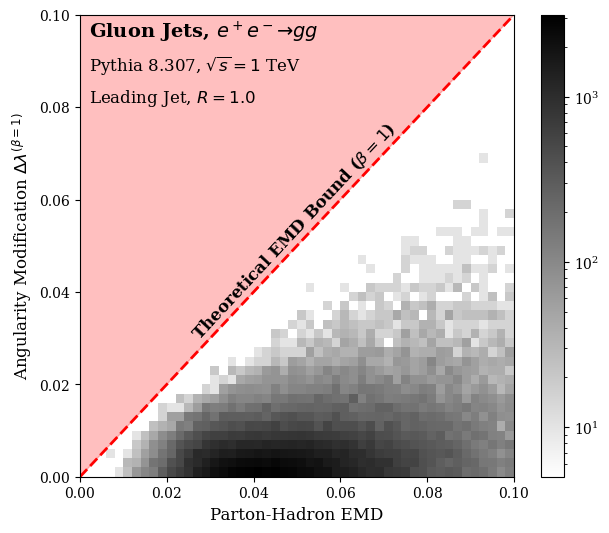

In [80]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,delta_lambda1,bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"Angularity Modification $\Delta\lambda^{(\beta=1)}$",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Gluon Jets, $e^+e^- \to gg$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/gjet_EMD_vs_lambda1_R1.0_pTinclusive.pdf")

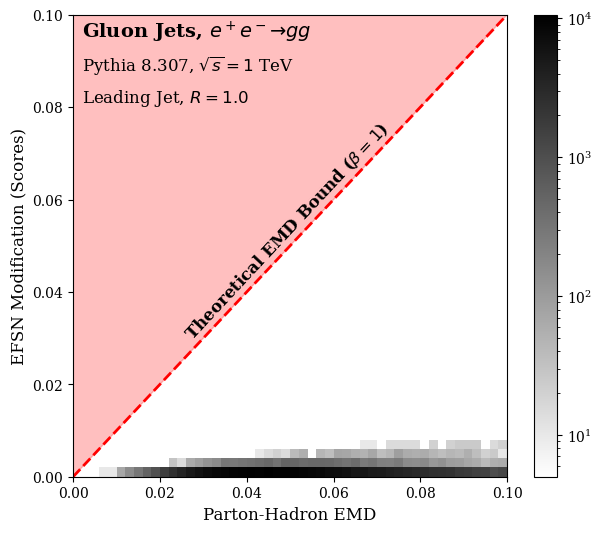

In [81]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_spectral_efn,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFSN Modification (Scores)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Gluon Jets, $e^+e^- \to gg$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/gjet_EMD_vs_spectralEFNscores_R1.0_pTinclusive.pdf")

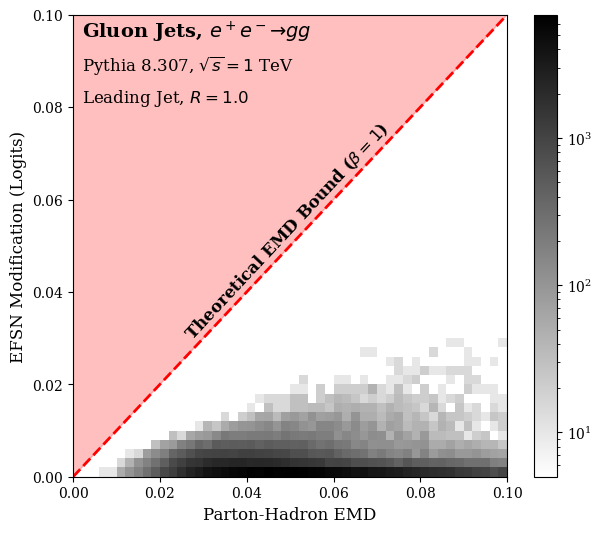

In [82]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_spectral_efn_logits,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFSN Modification (Logits)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
xtext = 0.002
ytext = 0.095
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(xtext,ytext,r"Gluon Jets, $e^+e^- \to gg$",fontsize=14,fontweight='bold')
plt.text(xtext,ytext-0.007,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(xtext,ytext-0.014,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/gjet_EMD_vs_spectralEFNlogits_R1.0_pTinclusive.pdf")

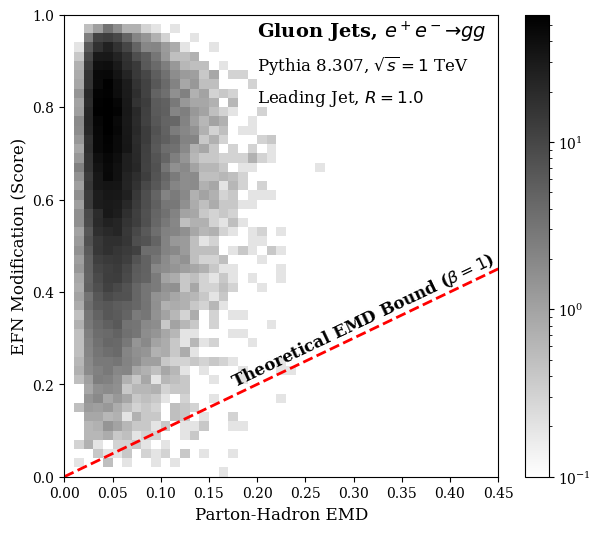

In [87]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.45
binstep = 0.01
binsx = np.arange(xmin,xmax+binstep,binstep)

ymin,ymax = 0,1
binstep = 0.02
binsy = np.arange(ymin,ymax+binstep,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_efn,axis=1),bins=(binsx,binsy),
                        norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFN Modification (Score)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = ymax*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
#plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.20,0.95,r"Gluon Jets, $e^+e^- \to gg$",fontsize=14,fontweight='bold')
plt.text(0.20,0.88,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.20,0.81,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.17,0.195,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=25.5)
plt.savefig("plots/gjet_EMD_vs_EFNscores_R1.0_pTinclusive.pdf")

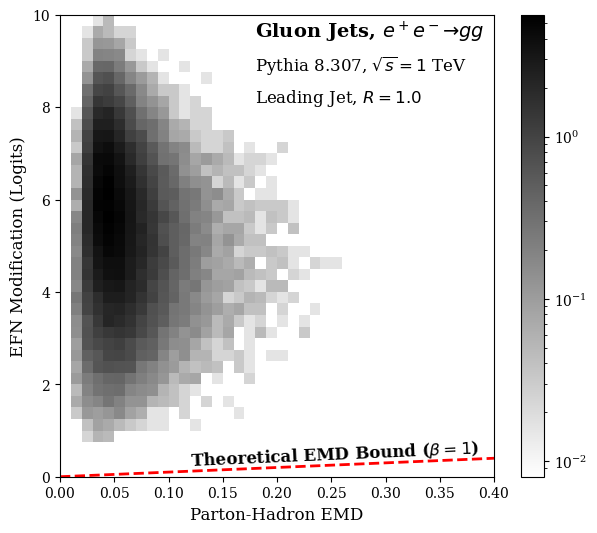

In [89]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.4
binstep = 0.01
binsx = np.arange(xmin,xmax+binstep,binstep)

ymin,ymax = 0,10
binstep = 0.25
binsy = np.arange(ymin,ymax+binstep,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_efn_logits,axis=1),bins=(binsx,binsy),
                        norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFN Modification (Logits)",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = ymax*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
#plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.18,9.5,r"Gluon Jets, $e^+e^- \to gg$",fontsize=14,fontweight='bold')
plt.text(0.18,8.8,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.18,8.1,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.12,0.25,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=2.5)
plt.savefig("plots/gjet_EMD_vs_EFNlogits_R1.0_pTinclusive.pdf")